# Creating a baseline model to assess if our model does better than trival 

In [2]:
!pip install lightgbm

In [106]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from joblib import dump, load

## Reading in the original data

In [107]:
wids = pd.read_csv("../../data/training_v2.csv", index_col = 'patient_id')
wids.head()

,encounter_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
patient_id,,,,,,,,,,,,,,,,,,,,,
25312,66154,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
59342,114252,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
50777,119783,118,0,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
46918,79267,118,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
34377,92056,33,0,19.0,NaN,0,Caucasian,M,188.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


## Dropping the columns that have over 70% missing values because we don't want to run any imputation on our baseline model 

In [62]:
# Dropping columns that have over than 70% missing values. 
missing_raw = pd.DataFrame(wids.isna().sum()/wids.shape[0]).reset_index()

cols_drop = missing_raw.loc[missing_raw[0]>0.7, 'index']
print(cols_drop)

wids.drop(cols_drop, axis=1, inplace=True)

25                fio2_apache
35               paco2_apache
36        paco2_for_ph_apache
37                pao2_apache
38                  ph_apache
45     d1_diasbp_invasive_max
46     d1_diasbp_invasive_min
53        d1_mbp_invasive_max
54        d1_mbp_invasive_min
63      d1_sysbp_invasive_max
64      d1_sysbp_invasive_min
71     h1_diasbp_invasive_max
72     h1_diasbp_invasive_min
79        h1_mbp_invasive_max
80        h1_mbp_invasive_min
89      h1_sysbp_invasive_max
90      h1_sysbp_invasive_min
117            d1_lactate_max
118            d1_lactate_min
127            h1_albumin_max
128            h1_albumin_min
129          h1_bilirubin_max
130          h1_bilirubin_min
131                h1_bun_max
132                h1_bun_min
133            h1_calcium_max
134            h1_calcium_min
135         h1_creatinine_max
136         h1_creatinine_min
139               h1_hco3_max
140               h1_hco3_min
141         h1_hemaglobin_max
142         h1_hemaglobin_min
143       

In [108]:
X = wids.drop('hospital_death', axis=1)
y = wids['hospital_death']

In [109]:
X1 = pd.get_dummies(X)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.2, random_state = 30, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(73370, 236) (18343, 236) (73370,) (18343,)


#  Using LGBM as our baseline model

In [9]:
# train
model_full = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=600,
                                learning_rate=0.1, n_estimators=50, reg_lambda=0.2)

model_full.fit(X_train, y_train)
y_pred = pd.Series(model_full.predict(X_test))
y_pred

0        0
1        0
2        0
3        0
4        0
        ..
18338    0
18339    0
18340    0
18341    0
18342    0
Length: 18343, dtype: int64

In [10]:
scores = cross_val_score(model_full, X_train, y_train, cv = 4, scoring = 'f1')
scores

array([0.43711522, 0.4291958 , 0.44493783, 0.43581826])

In [11]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[16571,   189],
       [ 1139,   444]])

In [13]:
print("Precision Score:", precision_score(y_test, y_pred))
print("Recall Score:",recall_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

Precision Score: 0.7014218009478673
Recall Score: 0.2804801010739103
F1 Score: 0.4007220216606498


In [14]:
y_prob_pred = model_full.predict_proba(X_test)
print(y_prob_pred)

[[0.97909894 0.02090106]
 [0.92095397 0.07904603]
 [0.99856799 0.00143201]
 ...
 [0.98453357 0.01546643]
 [0.99657448 0.00342552]
 [0.99564746 0.00435254]]


In [15]:
y_prob_pred = y_prob_pred[:,1]
r_a_score = roc_auc_score(y_test, y_prob_pred)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.8934141014990722


### Model Function

In [111]:
# create a dictionary of classifers with the hyperparameters you would like to try 
classifiers = {'LGB': LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=600,
                                learning_rate=0.1, n_estimators=50, reg_lambda=0.2)}

In [112]:
selected_clfs = ['LGB']

In [113]:
clf_matrix = pd.DataFrame(columns = ['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])

# for every classifier in the selected classifiers list
for idx, classifier in enumerate(selected_clfs):

    # get the classifier and hyperparameters from the model
    clf = classifiers[classifier]

    # fit the model 
    clf.fit(X_train,y_train)
    print(f"-------- classifier being run is {classifier} ---------")

    print(f"-------- saving the the model ---------")
    # Write the model to file
    dump(clf, '{}.joblib'.format(classifier)) 

    print(f"-------- computing y_predict, y_prob, y_train_predict ---------")
    # prediction of y based on X_test
    y_predict = clf.predict(X_test)
    # prediction of y probability based on X_test
    y_proba = clf.predict_proba(X_test)[:,1]
    # prediction of y based on X_train
    y_train_predict = clf.predict(X_train)

    print(f"-------- creating the confusion matrix ---------") 
    # confusion matrix 
    cmat = confusion_matrix(y_test, y_predict)
    # tp, fn, fp, tn
    tp = cmat[1,1]
    fn = cmat[1,0]
    fp = cmat[0,1]
    tn = cmat[0,0]

    print(f"-------- calculating the metrics ---------") 
    #precision score on test
    p_score_test = precision_score(y_test, y_predict)

    #recall score on test
    r_score_test = tp/(tp+fn) 

    #FPR score on test
    fpr_test = fp/(fp+tn)

    #AUROC score on test
    auroc_test = roc_auc_score(y_test, y_proba)

    #f1 score on test
    f1_test = f1_score(y_test, y_predict)

    #f1 score on train
    f1_train = f1_score(y_train, y_train_predict)

    #f1 score on cross validation 
    k_fold = 4
    f1_cv = cross_val_score(clf, X_train, y_train, cv=k_fold, scoring = 'f1').mean()
    print(f"Cross Validation is on {k_fold} folds.")

    print(f"-------- append values to the model matrix  ---------") 

    # append to matrix
    df2 = pd.DataFrame([[clf,p_score_test,r_score_test, fpr_test, auroc_test, f1_test, f1_train, f1_cv]], columns = ['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])
    
    clf_matrix = pd.concat([df2, clf_matrix])


-------- classifier being run is LGB ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------
Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------


In [114]:
# we are validating the scores of our original baseline against the scores we pull in our function above. 
clf_matrix
# scores match!!

,model,precision_test,recall_test,FPR_test,AUROC_test,f1_test,f1_train,f1_CV
0,"LGBMClassifier(boosting_type='gbdt', class_wei...",0.70178,0.2988,0.011993,0.894313,0.41914,0.999684,0.439461


In [130]:
def draw_conf_mat(mat):
    
    """
    Draw confusion matrix
    
    Parameters:
    ------------------
    mat:                ndarray of shape (n_classes, n_classes) 
                        confusion matrix

    """
    
    import matplotlib.pyplot as plt 
    import seaborn as sns
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(mat, annot=True, fmt="d",
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    
    return ax

LGB


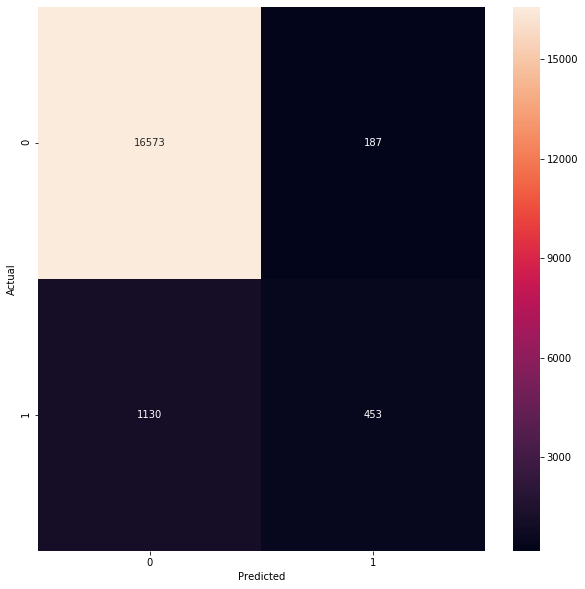

In [131]:
# Draw confusion matrix for each model 
for classifier in selected_clfs:

  # Load model saved
  clf = load('{}.joblib'.format(classifier)) 

  # Predict y based on X_test
  y_predict = clf.predict(X_test)

  # confusion matrix
  cm = confusion_matrix(y_test, y_predict)

  # Draw
  print(classifier)
  draw_conf_mat(cm)


# Kaggle Submission - Looking at our baseline with a holdout set

In [81]:
# testing the holdout data using our baseline model
wids_holdout = pd.read_csv(".../../data/unlabeled.csv")
wids_holdout.shape

(39308, 186)

In [82]:
encounter_id = wids_holdout['encounter_id']

In [67]:
# get dummies
wids_holdout = pd.get_dummies(wids_holdout)

In [87]:
print(X_train.shape)
print(wids_holdout.shape)

(73370, 179)
(39308, 186)


In [88]:
# Check the columns match between X_train and X_wids
list(set(X_train) - set(wids_holdout))

['apache_2_bodysystem_Gastrointestinal',
 'apache_2_bodysystem_Respiratory',
 'ethnicity_Other/Unknown',
 'ethnicity_Hispanic',
 'icu_admit_source_Floor',
 'ethnicity_Asian',
 'apache_3j_bodysystem_Musculoskeletal/Skin',
 'hospital_admit_source_Other ICU',
 'hospital_admit_source_ICU to SDU',
 'apache_3j_bodysystem_Respiratory',
 'apache_2_bodysystem_Metabolic',
 'apache_2_bodysystem_Cardiovascular',
 'icu_admit_source_Other Hospital',
 'apache_2_bodysystem_Haematologic',
 'apache_3j_bodysystem_Sepsis',
 'hospital_admit_source_Emergency Department',
 'icu_type_Cardiac ICU',
 'icu_type_CCU-CTICU',
 'apache_3j_bodysystem_Cardiovascular',
 'ethnicity_Caucasian',
 'apache_2_bodysystem_Renal/Genitourinary',
 'icu_type_CTICU',
 'ethnicity_African American',
 'icu_type_CSICU',
 'icu_admit_source_Other ICU',
 'ethnicity_Native American',
 'hospital_admit_source_Acute Care/Floor',
 'hospital_admit_source_Direct Admit',
 'apache_3j_bodysystem_Trauma',
 'apache_2_bodysystem_Undefined diagnoses',


In [89]:
list(set(wids_holdout) - set(X_train))

['h1_creatinine_max',
 'd1_lactate_min',
 'd1_sysbp_invasive_max',
 'h1_bilirubin_max',
 'h1_pao2fio2ratio_min',
 'h1_sysbp_invasive_max',
 'h1_wbc_min',
 'h1_hemaglobin_min',
 'h1_hco3_min',
 'h1_potassium_max',
 'h1_calcium_max',
 'h1_sysbp_invasive_min',
 'h1_wbc_max',
 'icu_stay_type',
 'icu_admit_source',
 'd1_sysbp_invasive_min',
 'h1_bun_min',
 'h1_bun_max',
 'hospital_admit_source',
 'h1_hematocrit_min',
 'h1_bilirubin_min',
 'd1_diasbp_invasive_max',
 'encounter_id',
 'h1_sodium_max',
 'd1_mbp_invasive_min',
 'gender',
 'ph_apache',
 'd1_diasbp_invasive_min',
 'h1_arterial_pco2_max',
 'h1_arterial_pco2_min',
 'fio2_apache',
 'h1_platelets_max',
 'h1_hematocrit_max',
 'paco2_for_ph_apache',
 'd1_mbp_invasive_max',
 'h1_calcium_min',
 'h1_potassium_min',
 'd1_pao2fio2ratio_min',
 'hospital_death',
 'h1_hco3_max',
 'h1_arterial_ph_max',
 'ethnicity',
 'apache_3j_bodysystem',
 'h1_lactate_max',
 'h1_platelets_min',
 'h1_arterial_po2_min',
 'icu_type',
 'h1_albumin_max',
 'paco2_ap

In [90]:
# Drop extra from X_train
wids_holdout.drop(list(set(wids_holdout) - set(X_train)), axis=1, inplace=True)
X_train.drop(list(set(X_train) - set(wids_holdout)), axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [101]:
# Retrain model
lgb = LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=600,
                                learning_rate=0.1, n_estimators=50, reg_lambda=0.2, random_state=1)
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=50, n_jobs=-1, num_leaves=600, objective='binary',
               random_state=1, reg_alpha=0.0, reg_lambda=0.2, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [102]:
results = lgb.predict_proba(wids_holdout)

In [103]:
submission = pd.DataFrame({'encounter_id': np.array(encounter_id), 
                           'hospital_death': results[:,1]})

In [104]:
submission.to_csv("uchicago_submission5.csv", index = False)

In [105]:
submission

,encounter_id,hospital_death
0,2,0.007382
1,5,0.010128
2,7,0.001583
3,8,0.049791
4,10,0.223070
...,...,...
39303,131035,0.001012
39304,131037,0.010658
39305,131039,0.064701
39306,131041,0.002455
